# Time-series Forecasting

## Description
The data consists of 52,416 observations of energy consumption on a 10-minute window. Every observation is described by the following feature columns.

Your task is to **aggregate the observations on an interval of 2 hours**. For this time interval, using the values of the **4 previous time intervals**, forecast the target value one step in the future. Choose which features you are going to use.

**You must train a Boosting model for the task. Choose the model based on the number, and type of features available.**



Features:

* Date: Time window of ten minutes.
* Temperature: Weather Temperature.
* Humidity: Weather Humidity.
* WindSpeed: Wind Speed.
* GeneralDiffuseFlows: “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
* DiffuseFlows

Target:

SolarPower

## Dataset links:
* [DS1](https://drive.google.com/file/d/1-Pcpb1xWpKc8Cgs-P7xqBFHw2NM0dBsA/view?usp=sharing)
* [DS2](https://drive.google.com/file/d/1-Pul07w6LXpm-uo99qbNc86FHhwl4yQD/view?usp=sharing)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from xgboost import XGBRegressor

## Read the datasets

In [4]:
df1=pd.read_csv('Datasets/power_consumption_g3_feat.csv')
df2=pd.read_csv('Datasets/power_consumption_g3.csv')

In [5]:
df1.head()

,Date,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
0,2017-03-01 16:40:00,21.33,55.91,0.080,387.400,427.300
1,2017-07-27 06:30:00,23.10,48.58,4.908,10.450,8.630
2,2017-10-11 19:00:00,23.10,59.82,0.084,0.446,0.322
3,2017-02-10 06:50:00,12.25,80.80,4.916,0.051,0.111
4,2017-03-06 16:00:00,15.62,59.38,0.075,533.400,579.900


In [6]:
df2.head()

,Date,SolarPower
0,2017-06-22 11:50:00,35818.80795
1,2017-04-24 22:50:00,34628.20237
2,2017-11-05 09:00:00,22781.53846
3,2017-10-19 23:20:00,31925.77681
4,2017-03-25 17:10:00,30246.12766


## Merge the datasets (and pre-processing if needed)

In [8]:
data = pd.merge(df1,df2, on='Date')
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Date,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,SolarPower
0,2017-03-01 16:40:00,21.33,55.91,0.080,387.400,427.300,32243.74468
1,2017-07-27 06:30:00,23.10,48.58,4.908,10.450,8.630,26356.94352
2,2017-10-11 19:00:00,23.10,59.82,0.084,0.446,0.322,46962.27571
3,2017-02-10 06:50:00,12.25,80.80,4.916,0.051,0.111,22173.55932
4,2017-03-06 16:00:00,15.62,59.38,0.075,533.400,579.900,33328.34043


## Group the datasets into time intervals of 2 hours

In [10]:
data.set_index('Date', inplace=True)

In [11]:
data_resampled = data.resample('2h').mean().dropna()
data_resampled.reset_index(inplace=True)
data_resampled.head()

,Date,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,SolarPower
0,2017-01-01 00:00:00,5.874636,76.154545,0.081917,0.060167,0.105667,26927.594937
1,2017-01-01 02:00:00,5.029333,78.008333,0.082583,0.061417,0.135083,21447.088607
2,2017-01-01 04:00:00,4.919667,74.641667,0.081667,0.061917,0.120833,20641.518987
3,2017-01-01 06:00:00,4.512750,74.575000,0.082417,0.063583,0.122500,20094.683545
4,2017-01-01 08:00:00,4.632167,73.791667,0.082417,79.281917,15.761833,21255.189872


## Create lags

In [13]:
n_lags = 4
for lag in range (1, n_lags +1):
    data_resampled[f'SolarPower_lag_{lag}'] = data_resampled['SolarPower'].shift(lag)

data_lagged = data_resampled.dropna()
data_lagged

,Date,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,SolarPower,SolarPower_lag_1,SolarPower_lag_2,SolarPower_lag_3,SolarPower_lag_4
4,2017-01-01 08:00:00,4.632167,73.791667,0.082417,79.281917,15.761833,21255.189872,20094.683545,20641.518987,21447.088607,26927.594937
5,2017-01-01 10:00:00,8.019333,63.835833,2.913333,346.072727,34.108333,27986.835442,21255.189872,20094.683545,20641.518987,21447.088607
6,2017-01-01 12:00:00,15.263333,57.075000,0.076167,486.391667,40.981667,30060.759495,27986.835442,21255.189872,20094.683545,20641.518987
7,2017-01-01 14:00:00,15.662500,56.914167,0.075667,377.458333,48.125000,29558.481012,30060.759495,27986.835442,21255.189872,20094.683545
8,2017-01-01 16:00:00,15.309167,59.112500,0.077250,160.075833,169.773333,31576.708860,29558.481012,30060.759495,27986.835442,21255.189872
...,...,...,...,...,...,...,...,...,...,...,...
4359,2017-12-30 14:00:00,14.513333,39.486364,0.077667,409.650000,42.163333,29293.789606,30490.240812,29649.683142,23720.152091,21307.984791
4360,2017-12-30 16:00:00,14.015000,43.236364,0.077500,153.905000,152.368333,31262.864386,29293.789606,30490.240812,29649.683142,23720.152091
4361,2017-12-30 18:00:00,10.112500,60.239091,0.075583,1.618917,1.676750,37721.673005,31262.864386,29293.789606,30490.240812,29649.683142
4362,2017-12-30 20:00:00,8.526667,66.832500,0.080917,0.062917,0.101667,36183.523447,37721.673005,31262.864386,29293.789606,30490.240812


# Split the dataset into 80% training and 20% testing datasets

In [15]:
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows'] + \
           [f'SolarPower_lag_{lag}' for lag in range(1, n_lags + 1)]
target = 'SolarPower'

## Create the model, pre-process the data and make it suitable for training

In [17]:
X = data_lagged[features]
y = data_lagged[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


print(f"Training data: {X_train.shape}, Testing data: {X_test.shape}")

Training data: (3488, 9), Testing data: (872, 9)


## Perofrm hyper-parameter optimization with a 5-fold cross validation.

Important: Do not use many values for the hyper-parameters due to time constraints.

KEEP IN MIND THE DATASET IS TIME-SERIES.

In [19]:
from sklearn.model_selection import GridSearchCV

model = XGBRegressor()

param_grid={
    'n_estimators':[50,100],
    'max_depth': [3,5],
    'learning_rate':[0.01, 0.1]
}

## Fit the model with the best parameters on the training dataset

In [21]:
grid_search = GridSearchCV(estimator= model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:",grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


## Calculate the adequate metrics on the testing dataset

In [23]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

In [24]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2= r2_score(y_test, y_pred)
print(f"R2:{r2}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


R2:0.892188336981987
MAE: 1505.7183234026184
RMSE: 1964.4259707695269


## Visualize the targets against the predictions

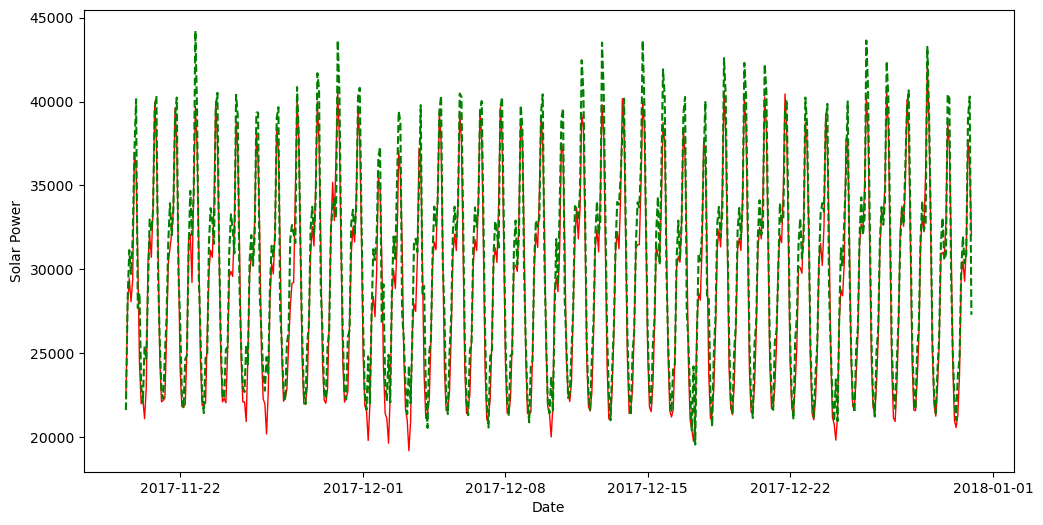

In [26]:
dates = data_lagged['Date'][-len(y_test):] #making date enough
subset = dates[-500:] #less date
plt.figure(figsize=(12, 6))
plt.plot(subset, y_test.values[-500:], label='Actual (y_test)', color='red', linewidth=1)
plt.plot(subset, y_pred[-500:], label='Predicted (y_pred)', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Solar Power')
plt.show()


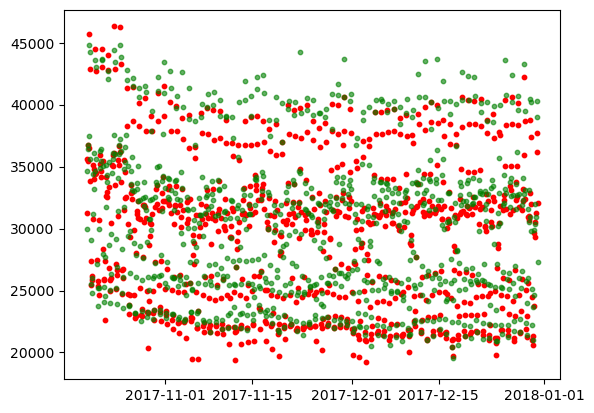

In [27]:
plt.scatter(dates, y_test.values, color='red', label='Actual', s=10)
plt.scatter(dates, y_pred, color='green', label='Predicted', s=10, alpha=0.6)

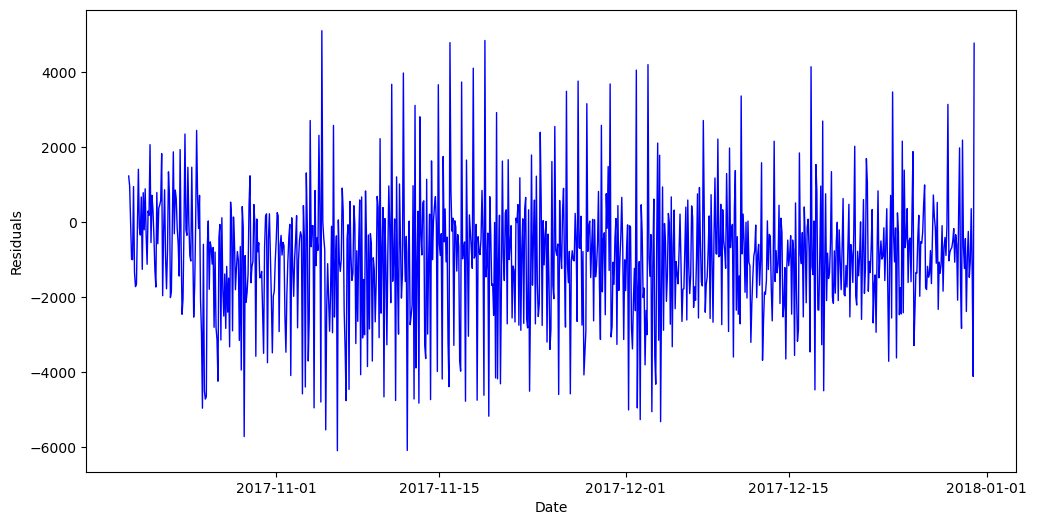

In [28]:
residuals = y_test.values - y_pred
plt.figure(figsize=(12, 6))
plt.plot(dates, residuals, label='Residuals', color='blue', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()